In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


In [ ]:
import pandas as pd
import numpy as np


In [4]:
sum = 0
pv = 745
r = 0.10
for i in range(1,21):
    a =i*(70/((1+r)**i))/pv
    print(a)
    sum = sum + a
sum + (1000/((1+r)**20))/pv

0.08541793776693105
0.1553053413944201
0.211780010992391
0.25670304362714064
0.29170800412175063
0.3182269135873643
0.33751339319871965
0.3506632656610074
0.35863288533512117
0.3622554397324456
0.3622554397324456
0.3592615931230865
0.35381823565152454
0.34639547546303096
0.33739819038606916
0.32717400279861253
0.3160203436122961
0.30419070508135454
0.2919001715427139
0.27933030769637696


6.205472348859357

In [4]:
std_a = 0.6
std_r = 0.4
corr = 0.9
rf = 0
q_a = 10000
q_r = 13500

v = math.sqrt((std_a*q_a)**2 + (std_r*q_r)**2 - 2*q_r*q_a*corr*std_a*std_r)
v

2615.339366124404

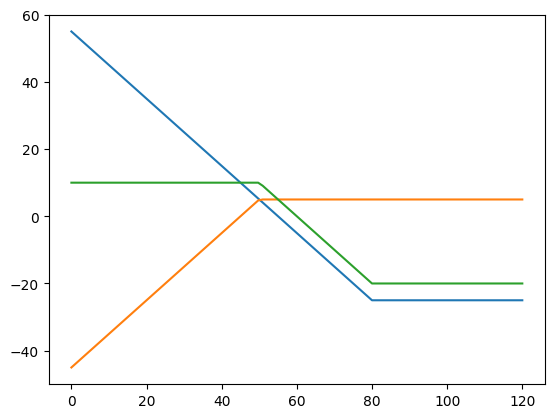

In [34]:
st = np.linspace(0,120,100)
x_call_long = 90
x_put_long = 80
x_call_short = 90
x_put_short = 50
def long_call(st):
    return max(st-x_call_long,0)
def long_put(st):
    return max(x_put_long-st,0)
def short_call(st):
    return -max(st-x_call_short,0)
def short_put(st):
    return -max(x_put_short-st,0)
long_call_payoff = np.vectorize(long_call)(st)
long_put_payoff = np.vectorize(long_put)(st)
short_call_payoff = np.vectorize(short_call)(st)
short_put_payoff = np.vectorize(short_put)(st)
plt.plot(st,long_put_payoff-25)
plt.plot(st,short_put_payoff+5)
plt.plot(st,long_put_payoff+short_put_payoff-20)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import requests

names = ['year', 'month', 'day', 'dec_year', 'sn_value',
         'sn_error', 'obs_num', 'unused1']

df = pd.read_csv(
    "SN_d_tot_V2.0.csv",sep=';',header=None,names=names,na_values=' -1',)
df['sn_value'] = df['sn_value'].fillna(df['sn_value'].mean())
df['sn_value']

0        -1
1        -1
2        -1
3        -1
4        -1
         ..
72860    21
72861    19
72862    17
72863    12
72864    11
Name: sn_value, Length: 72865, dtype: int64

In [37]:
# Data Preprocessing
df = pd.read_csv(
    "SN_d_tot_V2.0.csv",sep=';',header=None,names=names,na_values=' -1',)
start_id = max(df[df['obs_num'] == 0].index.tolist()) + 1
df = df[start_id:].copy()
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year'] < 2000]
df_test = df[df['year'] >= 2000]

spots_train = df_train['sn_value'].to_numpy().reshape(-1, 1)
spots_test = df_test['sn_value'].to_numpy().reshape(-1, 1)
spots_test

array([[71.],
       [75.],
       [80.],
       ...,
       [17.],
       [12.],
       [11.]])

In [24]:

df = pd.DataFrame(data=np.random.randn(1000, 4), columns=['a', 'b','c','d'])
df['sum'] = df.sum(axis=1) + np.random.rand()
df_train = df[:df.shape[0]*4//5]
df_test = df[df.shape[0]*4//5:]

y = 'sum'

spots_train = df_train[y].to_numpy().reshape(-1, 1)
spots_test = df_test[y].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

print("sequenced already!")


# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_loader.batch_size

# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

import torch

device = (
    "mps"
    if getattr(torch, "has_mps", False)
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")


model = TransformerModel().to(device)

sequenced already!
Using device: mps


/var/folders/_b/4lj1bh0s4473m5xx061k14lc0000gn/T/ipykernel_89301/30439550.py:84: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  if getattr(torch, "has_mps", False)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [25]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Epoch 1/1000, Validation Loss: 1.0724
Epoch 2/1000, Validation Loss: 1.0631
Epoch 3/1000, Validation Loss: 1.0554
Epoch 4/1000, Validation Loss: 1.0747


KeyboardInterrupt: 

800

In [13]:
df['id'] = df.index +1
df['sum'] = df['sum'].astype(float)
threshold_train_test = df.shape[0]*4//5
df_train = df[:,:df.shape[0]*4//5]
df_test = df[df.shape[0]*4//5]


InvalidIndexError: (slice(None, None, None), slice(None, 800, None))

array([[71.],
       [75.],
       [80.],
       ...,
       [17.],
       [12.],
       [11.]])

In [33]:
# Data Preprocessing
df = pd.read_csv(
    "SN_d_tot_V2.0.csv",sep=';',header=None,names=names,na_values=' -1',)
start_id = max(df[df['obs_num'] == 0].index.tolist()) + 1
df = df[start_id:].copy()
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year'] < 2000]
df_test = df[df['year'] >= 2000]

spots_train = df_train['sn_value'].to_numpy().reshape(-1, 1)
spots_test = df_test['sn_value'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_loader.batch_size

# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

import torch

device = (
    "mps"
    if getattr(torch, "has_mps", False)
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")


model = TransformerModel().to(device)

Using device: mps


/var/folders/_b/4lj1bh0s4473m5xx061k14lc0000gn/T/ipykernel_80305/3304198112.py:83: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  if getattr(torch, "has_mps", False)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [34]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Epoch 1/1000, Validation Loss: 0.0497
Epoch 2/1000, Validation Loss: 0.0475
Epoch 3/1000, Validation Loss: 0.0690
Epoch 4/1000, Validation Loss: 0.0407
Epoch 5/1000, Validation Loss: 0.0514
Epoch 6/1000, Validation Loss: 0.0427
Epoch 7/1000, Validation Loss: 0.0405
Epoch 8/1000, Validation Loss: 0.0382
Epoch 9/1000, Validation Loss: 0.0577
Epoch 10/1000, Validation Loss: 0.0360
Epoch 11/1000, Validation Loss: 0.0361
Epoch 12/1000, Validation Loss: 0.0402
Epoch 13/1000, Validation Loss: 0.0370
Epoch 14/1000, Validation Loss: 0.0357
Epoch 15/1000, Validation Loss: 0.0364
Epoch 16/1000, Validation Loss: 0.0386
Epoch 17/1000, Validation Loss: 0.0391
Epoch 18/1000, Validation Loss: 0.0355
Epoch 19/1000, Validation Loss: 0.0394
Epoch 20/1000, Validation Loss: 0.0381
Epoch 21/1000, Validation Loss: 0.0387


KeyboardInterrupt: 

In [9]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("MergedFinalData3.0.csv")
#for protocol  in data['protocol'].unique():
#    print(data[data['protocol'] == protocol]['TVL'].mean(),protocol)
data['protocol'].unique()

array(['dydx', 'umami', 'gns', 'bifi', 'looks', 'rbn', 'rdt', 'dpx',
       'gmx', 'crv', 'snx'], dtype=object)

In [12]:
n = 30
test_df = pd.DataFrame({'TVL':np.random.randint(0,100,size= n),'protocol':np.random.choice(['dydx','rbn','rdt'],n),'year': np.array([i for i in range(2022-n//2,2022+n//2)])})
df = test_df
df

,TVL,protocol,year
0,54,rdt,2007
1,40,rdt,2008
2,91,rdt,2009
3,48,rbn,2010
4,13,dydx,2011
5,27,rbn,2012
6,45,rdt,2013
7,45,rbn,2014
8,64,rdt,2015
9,46,rbn,2016


In [13]:
pd.read_csv("https://github.com/BACCHUS2333/homework3.github.io/blob/main/2023-05-11%2010-53-32zhihu_hot.csv")

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>

In [28]:
import pandas as pd
import io
import requests
url = "https://raw.githubusercontent.com/BACCHUS2333/homework3.github.io/main/frax.csv"
url = "https://raw.githubusercontent.com/BACCHUS2333/homework2.github.io/main/MergedFinalData3.0.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8'))).iloc[:,1:]
c.head()
c['protocol'].unique()


array(['dydx', 'umami', 'gns', 'bifi', 'looks', 'rbn', 'rdt', 'dpx',
       'gmx', 'crv', 'snx'], dtype=object)

In [32]:
import matplotlib.pyplot as plt


,TVL,protocol,year
0,96,rbn,2007
1,52,rbn,2008
2,33,rbn,2009
3,42,rdt,2010
4,28,rdt,2011
5,61,dydx,2012
6,91,dydx,2013
7,75,rdt,2014
8,73,rdt,2015
9,53,rbn,2016
